**9.2 순환 신경망으로 IMDB 리뷰 분류하기**

**1) IMDB 리뷰 데이터셋**

**토큰(token)** : 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리한 단어

1개의 토근이 하나의 타임스텝에 해당

토큰에 할당하는 정수 중 특정한 용도 

(1) 0 : padding
(2) 1 : 문장의 시작
(3) 2 : 어휘 사전에 없는 토큰

어휘사전 : 훈련 세트에서 고유한 단어를 뽑아 만든 목록

In [1]:
# tensorflow.keras.dataest 패키지의 imdb모듈을 임포트

import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words= 500)

17473536/17464789 [==============================] - 0s 0us/step


In [3]:
print(train_input.shape, test_input.shape)

# 훈련 세트와 테스트 세트가 각각 25000개의 샘플로 구성

(25000,) (25000,)


In [4]:
# IMDB 리뷰 텍스트는 길이가 제각각
# 따라서 고정 크기의 2차원 배열에 담기 보다는 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용

# 첫 번째 리뷰의 길이 출력

print(len(train_input[0]))
# 첫 번째 리뷰의 길이는 218개의 토큰으로 이루어져 있음

218


In [6]:
print(len(train_input[1]))
# 두 번째 리뷰의 길이는 189개의 토큰으로 구성

189


In [8]:
# 하나의 리뷰가 하나의 샘플이 됨

# 첫 번째 리뷰에 담긴 내용 출력

print(train_input[0])

# num_words= 500으로 지정 ==> 어휘 사전에는 500개의 단어만 들어가 있음
# 어휘사전에 없는 단어는 2로 표시

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [12]:
# 타깃 데이터 출력
print(train_target[:20])

# 리뷰가 긍정인지 부정인지 판단
# 이진 분류 문제 : 0(부정) 1(긍정)

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [13]:
# 훈련 데이터에서 검증 데이터 분리

from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size= 0.2, random_state= 42)

In [14]:
# 각 리뷰의 길이를 계산해 numpy 배열에 저장
# 리뷰의 평균 길이와 최소, 최대 길이 파악

import numpy as np

lengths = np.array([len(x) for x in train_input])

In [15]:
# np.mean(), np.median()을 이용해 리뷰 길이의 평균과 중간값 계산

print(np.mean(lengths), np.median(lengths))

239.00925 178.0


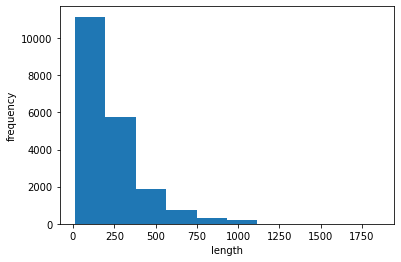

In [16]:
# 히스토그램으로 lenghts의 배열 출력

import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [18]:
# 중간값 보다 짧은 100개의 단어만 사용
# 100개의 단어보다 작은 리뷰에는 길이를 100에 맞추기 위해 padding이 필요
# 패딩을 나타내는 토큰으로 0을 사용
# pad_sequences() 메서드를 통해 길이를 100으로 padding

from keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen= 100)

# maxlen에 원하는 길이를 지정 -> 100보다 긴 경우 잘라내고, 짧은 경우 0으로 padding

In [20]:
print(train_seq.shape)

# train_input은 파이썬 리스트 배열이었지만 길이를 100으로 padding한 train_seq는 (20000, 100) 크기의 2차원 배열이 됨

(20000, 100)


In [21]:
# train_seq에 있는 첫 번째 샘플 출력

print(train_seq[0])

# 샘플 앞뒤에 padding값 0이 없음 ==> 100보다 길다

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [23]:
print(train_input[0][-10 :])

# 음수 인덱스와 슬라이싱을 통해 train_input[0]에 있는 마지막 10개의 토큰 출력
# train_seq[0]과 일치함 ==> train_input[0]의 앞부분이 잘림

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [24]:
# pad_sequences() 메서드는 기본적으로 maxlen보다 긴 시퀀스의 앞부분을 잘라냄
# 일반적으로 시퀀스의 뒷부분의 정보가 더 유용하리라 기대하기 때문
# 만약 시퀀스의 뒷부분을 잘라내고 싶다면 pad_sequences() 메서드의 truncating 매개변수의 값을 기본값 'pre'가 아닌 'post'로 변경할 것

In [26]:
# train_seq에 있는 여섯 번째 샘플 출력

print(train_seq[5])
# 앞부분에 padding 값 0 존재 ==> 샘플의 길이가 100 보다 짧음
# padding 값은 앞부분에 추가 됨

# 시퀀스 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향 ==> 마지막에 패딩 추가하는 것은 선호되지 않음

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [27]:
# 검증 세트의 길이 100으로 수정

val_seq = pad_sequences(val_input, maxlen= 100)

print(val_seq.shape)

(5000, 100)


**2) 순환 신경망 만들기**

In [29]:
model = keras.models.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape= (100, 500)))   # activation은 기본값인 tanh(hyperbolic tangent) 사용
# 샘플의 길이를 100으로 padding 하였으므로 첫 번째 차원은 100
# 토큰을 정수로 변환한 데이터를 신경망에 주입 -> 큰 정수가 큰 활성화 출력 ==> 단순한 정수값을 신경망에 주입하기 위해 다른 방식 필요
# 정수값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하는 방법 = one-hot encoding
model.add(keras.layers.Dense(1, activation= 'sigmoid'))

In [30]:
# 만약 train_seq[0]의 첫 번째 토큰인 10을 one-hot encoding으로 변환 -> 열한 번째 원소만 1, 나머지는 0인 배열
# imdb.load_data() 함수에서 num_words= 500으로 지정하였기 때문에 고유한 단어는 500개
# 훈련 데이터에 포함될 수 있는 정수값의 범위는 0(padding token)에서 499까지, 총 500개
# 따라서 이 범위를 one-hot encoding으로 표현하려면 배열의 길이가 500이어야 함

In [31]:
# keras의 one-hot encoding 유틸리티 to_categorical() 메서드를 사용하여 변환

train_oh = keras.utils.to_categorical(train_seq)

In [32]:
print(train_oh.shape)

# 정수 하나마다 모두 500 차원의 배열로 변경되었기 때문에 (20000, 100)에서 (20000, 100, 500)으로 변환

(20000, 100, 500)


In [33]:
# 따라서 SimppleRNN 클래스의 input_shape= (100,500)으로 지정

In [34]:
# train_oh의 첫 번째 샘플의 첫 번째 토큰 10의 one-hot encoding 확인

print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [35]:
# 나머지 원소가 0인지 확인

print(np.sum(train_oh[0][0]))

1.0


In [36]:
# val_seq one-hot encoding

val_oh = keras.utils.to_categorical(val_seq)

In [37]:
# Model Summary()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 4072      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


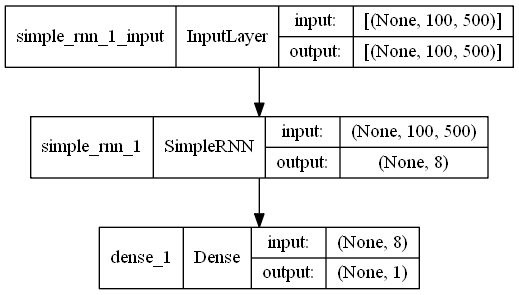

In [38]:
keras.utils.plot_model(model, show_shapes= True)

In [39]:
# 순환층에 사용된 모델 파라미터 수 계산
# 입력 토큰은 500차원의 one-hot encoding 배열
# 순환층의 뉴런 8개와 완전 연결
# 500 x 8 = 4000개의 가중치
# 순환층의 은닉 상태는 다시 다음 타임스텝에 사용을 위해 또 다른 가중치와 곱해짐
# 이 은닉 상태도 순환층의 뉴런과 완전 연결 : 8(은닉 상태 크기) x 8(뉴런의 개수) = 64개의 가중치가 필요
# 뉴런 마다 하나의 절편이 존재
# 따라서 4000 + 64 + 8 = 4072개의 모델 파라미터 필요

**3) 순환 신경망 훈련하기**

In [40]:
# RMSprop의 학습률 0.001을 사용하지 않기 위해 별도의 RMSprop 객체를 만들어 학습률을 0.0001로 지정
rmsprop = keras.optimizers.RMSprop(learning_rate= 1e-4)

# Epochs 100, batch_size= 64

model.compile(
    optimizer= rmsprop,
    loss= 'binary_crossentropy',
    metrics= ['accuracy']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only= True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)

history = model.fit(train_oh, train_target,
                    epochs= 100,
                    batch_size= 64,
                    validation_data=(val_oh, val_target),
                    callbacks= [checkpoint_cb, early_stopping_cb]
                    )


Epoch 1/100
313/313 [==============================] - 35s 108ms/step - loss: 0.6989 - accuracy: 0.5128 - val_loss: 0.6927 - val_accuracy: 0.5302
Epoch 2/100
313/313 [==============================] - 33s 106ms/step - loss: 0.6781 - accuracy: 0.5734 - val_loss: 0.6724 - val_accuracy: 0.5962
Epoch 3/100
313/313 [==============================] - 34s 108ms/step - loss: 0.6585 - accuracy: 0.6161 - val_loss: 0.6546 - val_accuracy: 0.6312
Epoch 4/100
313/313 [==============================] - 33s 107ms/step - loss: 0.6391 - accuracy: 0.6518 - val_loss: 0.6361 - val_accuracy: 0.6570
Epoch 5/100
313/313 [==============================] - 34s 109ms/step - loss: 0.6185 - accuracy: 0.6824 - val_loss: 0.6158 - val_accuracy: 0.6824
Epoch 6/100
313/313 [==============================] - 34s 109ms/step - loss: 0.5921 - accuracy: 0.7148 - val_loss: 0.5893 - val_accuracy: 0.7208
Epoch 7/100
313/313 [==============================] - 34s 108ms/step - loss: 0.5724 - accuracy: 0.7319 - val_loss: 0.5726 -

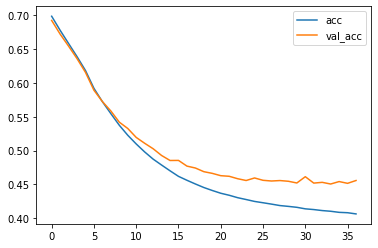

In [44]:
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'])
plt.show()

In [47]:
# 입력 데이터 one-hot encoding으로 변환 시 입력 데이터가 커짐

print(train_oh.nbytes, val_oh.nbytes)

# 토큰 1 개를 500차원으로 변경하여 발생하는 문제점

4000000000 1000000000


**4) 단어 임베딩**

**단어 임베딩(word embedding)**

각 단어를 고정된 크기의 실수 벡터로 변환

one-hot encoding 벡터보다 훨씬 의미 있는 값으로 채워져 있음 ==> 자연어 처리에서 더 좋은 성능

**keras.layers.Embedding()** 사용

모델에 추가하면 모든 벡터가 랜덤하게 초기화 됨

장점 : 입력으로 정수 데이터를 사용 ==> one-hot encoding된 train_oh가 아닌 train_seq를 사용 가능 ==> 메모리 효율적

(100,) 크기의 샘플을 (100,20)과 같이 2차원 배열로 변환

In [49]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_length= 100))
# 500 : 어휘 사전
# 16 : 임베딩 벡터 크기
# input_length : 입력 시퀀스의 길이 , 샘플의 길이를 100으로 padding 하여 train_seq 생성하였기 때문에 100으로 설정
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation= 'sigmoid'))

In [51]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________


In [53]:
# 모델 파라미터 계산

# Embedding 클래스는 500개의 각 토큰을 크기가 16인 벡터로 변경 : 500 * 16 = 8,000개의 파라미터
# SimpleRNN 층은 임베딩 벡터의 크기가 16이므로 8개의 뉴런과 곱해짐 : 16 * 8 = 128
# 은닉 상태에 곱해지는 가중치 8 * 8 = 64
# 8개의 절편 존재
# 따라서 순환층에 있는 전체 모델 파라미터는 128 + 64 + 8 = 200
# Dense층의 가중치 : 9

In [54]:
# one-hot encoding 보다 SimpleRNN에 주입되는 입력 크기는 감소하였지만 임베딩 벡터는 단어를 잘 표현 ==> 훈련 결과 개선될 것

rmsprop = keras.optimizers.RMSprop(learning_rate= 0.0001)

model2.compile(
    optimizer= rmsprop,
    loss= 'binary_crossentropy',
    metrics= ['accuracy']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', save_best_only= True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)

history = model2.fit(
    train_seq, train_target,
    epochs= 100,
    batch_size= 64,
    validation_data= (val_seq, val_target),
    verbose= 1,
    callbacks= [checkpoint_cb, early_stopping_cb]
)


Epoch 1/100
313/313 [==============================] - 44s 139ms/step - loss: 0.6922 - accuracy: 0.5253 - val_loss: 0.6728 - val_accuracy: 0.5864
Epoch 2/100
313/313 [==============================] - 44s 142ms/step - loss: 0.6360 - accuracy: 0.6509 - val_loss: 0.6151 - val_accuracy: 0.6776
Epoch 3/100
313/313 [==============================] - 45s 143ms/step - loss: 0.5848 - accuracy: 0.7133 - val_loss: 0.5757 - val_accuracy: 0.7182
Epoch 4/100
313/313 [==============================] - 45s 143ms/step - loss: 0.5480 - accuracy: 0.7469 - val_loss: 0.5500 - val_accuracy: 0.7380
Epoch 5/100
313/313 [==============================] - 43s 138ms/step - loss: 0.5224 - accuracy: 0.7646 - val_loss: 0.5292 - val_accuracy: 0.7546
Epoch 6/100
313/313 [==============================] - 43s 138ms/step - loss: 0.5049 - accuracy: 0.7737 - val_loss: 0.5221 - val_accuracy: 0.7558
Epoch 7/100
313/313 [==============================] - 44s 140ms/step - loss: 0.4909 - accuracy: 0.7817 - val_loss: 0.5051 -

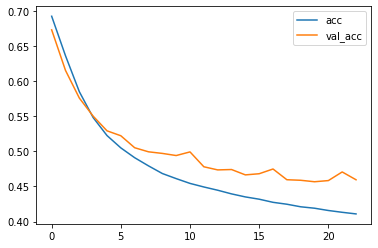

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'])
plt.show()